In [1]:

from attorch.dataset import ListDataset
from blinkende_lichter.datatools import RandomFlip, TypeConversion 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import numpy as np 
import numpy as np
import torch

from PIL import Image
from argparse import ArgumentParser

from torch.optim import Adam
from torch.autograd import Variable

from blinkende_lichter.unet.network import UNet
from blinkende_lichter.unet.criterion import CrossEntropyLoss2d

from random import randint
import matplotlib.pyplot as plt
import random

In [2]:

transform = transforms.Compose([    
    RandomFlip(),    
    TypeConversion(np.float32, np.long) ]) 
dat = np.load('../datasets/data_interpolated.npz')

tr = dat['train']
vd = dat['validation']
for image in tr[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
    

for image in vd[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
               


            
            
train = ListDataset(*tr, transform=transform)

val = ListDataset(*vd) 
trainloader = DataLoader( train, shuffle=True, batch_size=1) 
for x, y in trainloader:
    print(x.size(), y.size())
images, labels = next(iter(trainloader))

torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])


In [3]:
NUM_CHANNELS = 2
NUM_CLASSES = 2
NUM_CHECKS = 10


Net = UNet
model = Net(NUM_CLASSES)
model.load_state_dict(torch.load("model_data"))
model = model.cuda()

In [4]:
model.train()
weight = torch.ones(NUM_CLASSES)
weight[0] = 0      
criterion = CrossEntropyLoss2d()
optimizer = Adam(model.parameters())
epoch_loss = []
for epoch in range(1, 7001):
    for step, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        epoch_loss.append((loss.data[0]))
        
torch.save(model.state_dict(), "model_data")
torch.save(inputs, "inputs")
torch.save(targets, "targets")
torch.save(outputs, "outputs")
torch.save(epoch_loss, "loss")

print("Training complete.")

Training complete.


In [7]:
model.eval()
test_inputs = []
test_targets = []
test_outputs = []
for i in range(len(val.data[0])):
    input = torch.FloatTensor(val.data[0][i]).cuda()
    target = val.data[1][i]
    output = model(Variable(input).unsqueeze(0))
    test_inputs.append(input)
    test_targets.append(target)
    test_outputs.append(output)

print("Evaluation complete.")

Evaluation complete.


In [5]:
%matplotlib inline

In [8]:
n=0

in_img = test_inputs[n].cpu().numpy()
in_img_avg = in_img[0]
in_img_corr = in_img[1]
tgt_img = test_targets[n]

out_mod = []

out_data = test_outputs[n].data.cpu().numpy()
indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1)


In [60]:
out_mod = []

for n in range(len(test_outputs)):
    out_data = test_outputs[n].data.cpu().numpy()
    indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
    np.sum(out_data*indicator, axis=1)
    x = np.exp(out_data)
    res = x/x.sum(1)
    pos = np.argmax(res, axis=1)
    out_mod.append(pos.squeeze())

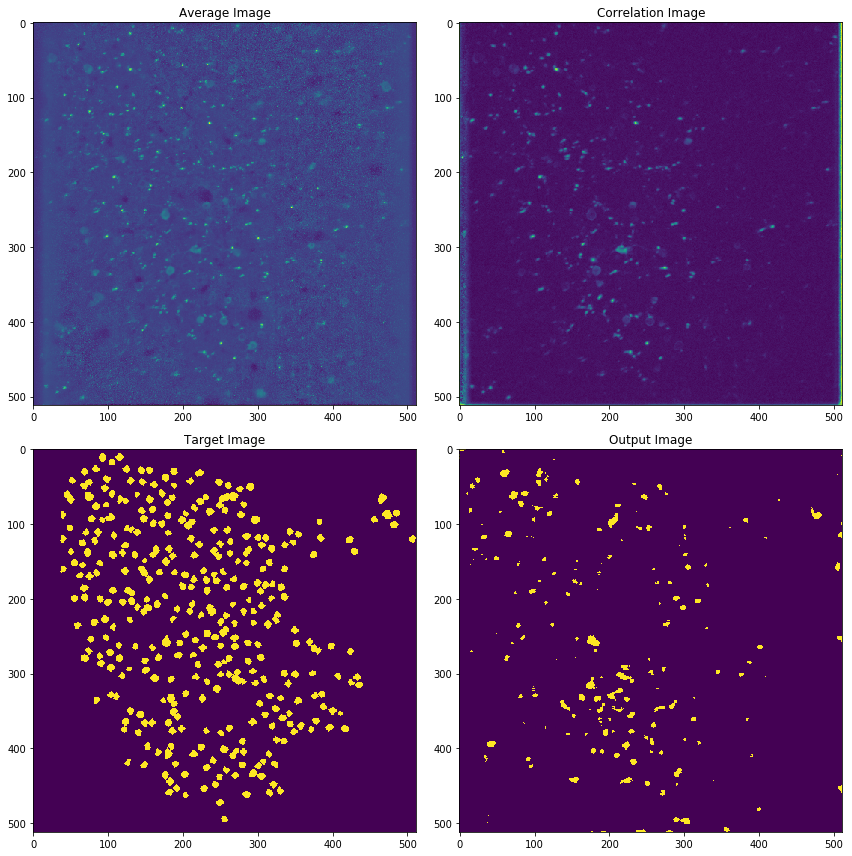

In [46]:
plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)

avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_img_avg)
corr.imshow(in_img_corr)
tgt.imshow(tgt_img)
out.imshow(pos.squeeze())



plt.tight_layout()

In [ ]:
dat['train'][1][0]

In [ ]:
np.unique(target.cpu().numpy())

In [ ]:
label = vd
fig = plt.figure(figsize=(12,12))
plt.imshow(label)
plt.colorbar()

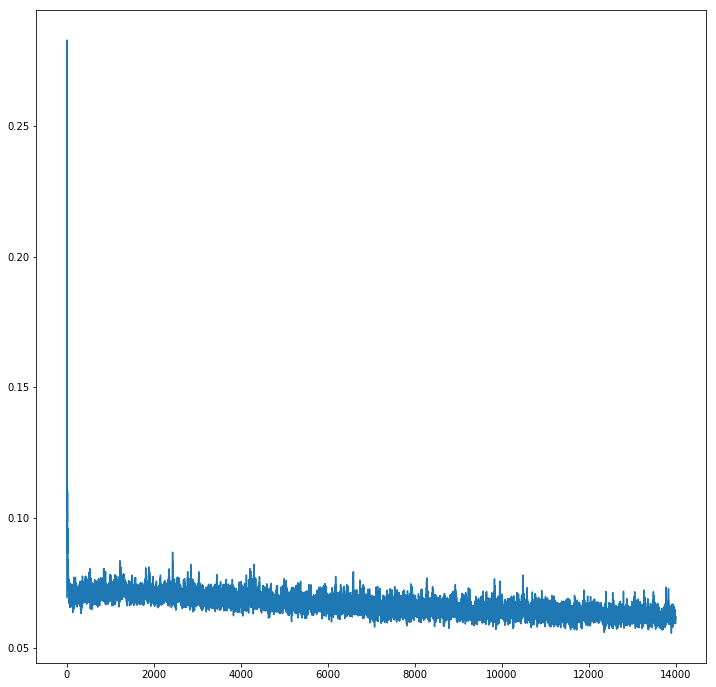

In [6]:
fig = plt.figure(figsize=(12,12))
plt.plot(epoch_loss)

<function matplotlib.pyplot.tight_layout>

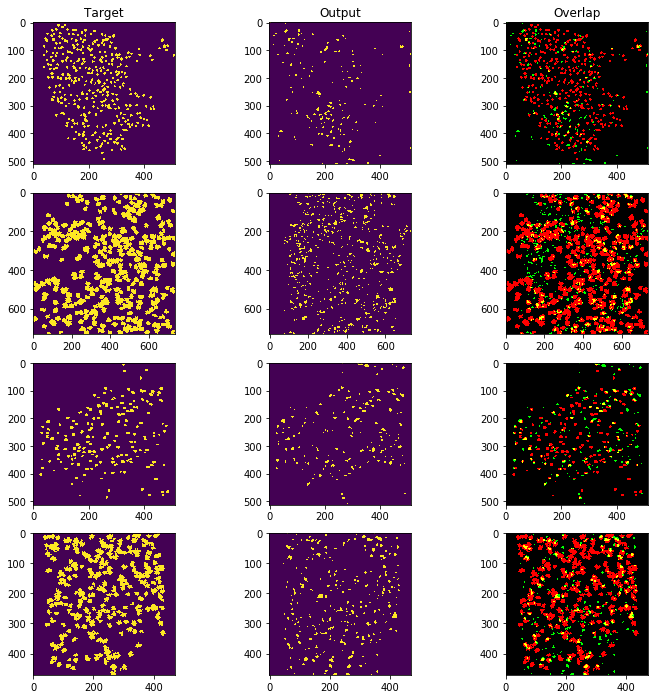

In [75]:
plt.figure()
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(12,12))
ax[0][0].title.set_text("Target")
ax[0][1].title.set_text("Output")
ax[0][2].title.set_text("Overlap")
overlaps = []
for i in range(len(test_targets)):
    ax[i][0].imshow(test_targets[i])
    
for j in range(len(out_mod)):
    ax[j][1].imshow(out_mod[j])
    
for k in range(len(out_mod)):
    image = out_mod[k]
    ol = np.zeros((len(image),len(image), 3))
    for h in range(len(image)):
        for w in range(len(image)):
            ol[w][h][0]=test_targets[k][w][h]
            ol[w][h][1]=image[w][h]
    overlaps.append(ol)

for o in range(len(overlaps)):
    ax[o][2].imshow(overlaps[o])
    

plt.tight_layout


In [52]:
test_targets[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [59]:
len(test_outputs)

4

In [69]:
image = out_mod[0]

In [70]:
len(image)

512

In [72]:
test_targets[0][0][0]

0

In [76]:
outputs

Variable containing:
( 0 , 0 ,.,.) = 
    0.0000    0.0000    0.0000  ...     0.0000    0.0000   -0.0019
    0.0000    0.0000    0.0000  ...     0.0000   -0.0000   -0.0117
    0.0000    0.0000    0.0000  ...     0.0000   -0.0000   -0.0367
              ...                ⋱                ...             
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 1 ,.,.) = 
  -44.1740  -42.3585  -41.2045  ...   -22.5133  -17.3062   -6.2463
  -39.4976  -38.9089  -39.5978  ...   -20.0217  -12.9535   -4.4573
  -42.5721  -43.0321  -43.5581  ...   -19.4342  -11.6099   -3.3243
              ...                ⋱                ...             
  -32.1169  -32.4422  -30.2008  ...   -86.2606  -70.6738  -65.9782
  -33.5997  -33.6253  -34.6794  ...   -91.0496  -59.6881  -67.6080
  -28.5862  -29.8430  -31.5117  ...   -84.0081  -60.7930  -62.3729
[torch

In [83]:
randint(0, len(inputs)-1)

0

In [85]:
inputs

Variable containing:
( 0 , 0 ,.,.) = 
  -1.7646  -1.5281  -2.0011  ...   -1.1339  -1.2127  -1.2915
  -1.9223  -1.8434  -1.8434  ...   -0.6608  -1.2127  -1.0550
  -1.5281  -1.9223  -1.7646  ...   -0.8973  -1.2915  -1.1339
            ...               ⋱              ...            
  -2.0011  -1.6857  -1.5281  ...   -1.2127  -1.2127  -1.2915
  -1.9223  -1.7646  -1.8434  ...   -1.2127  -1.2127  -1.2915
  -1.9223  -1.7646  -1.6857  ...   -1.2127  -1.1339  -1.2915

( 0 , 1 ,.,.) = 
   7.7494   6.1763   7.0839  ...    7.5679   8.4754   9.9275
   7.2654   3.9982   2.2436  ...    3.8167   6.5999   9.4435
   7.9309   4.3007   1.6386  ...    3.8772   7.5679  10.2300
            ...               ⋱              ...            
   7.9914   3.2722   1.5176  ...    2.3646   5.2083   9.0805
   8.4754   4.7848   5.0268  ...    3.7562   6.0553   8.8385
   8.8990   7.7494   8.3544  ...    7.0234   7.6284   9.4435
[torch.cuda.FloatTensor of size 1x2x512x512 (GPU 0)]

In [87]:
step

1

In [88]:
images


( 0 , 0 ,.,.) = 
  -1.7646  -1.5281  -2.0011  ...   -1.1339  -1.2127  -1.2915
  -1.9223  -1.8434  -1.8434  ...   -0.6608  -1.2127  -1.0550
  -1.5281  -1.9223  -1.7646  ...   -0.8973  -1.2915  -1.1339
            ...               ⋱              ...            
  -2.0011  -1.6857  -1.5281  ...   -1.2127  -1.2127  -1.2915
  -1.9223  -1.7646  -1.8434  ...   -1.2127  -1.2127  -1.2915
  -1.9223  -1.7646  -1.6857  ...   -1.2127  -1.1339  -1.2915

( 0 , 1 ,.,.) = 
   7.7494   6.1763   7.0839  ...    7.5679   8.4754   9.9275
   7.2654   3.9982   2.2436  ...    3.8167   6.5999   9.4435
   7.9309   4.3007   1.6386  ...    3.8772   7.5679  10.2300
            ...               ⋱              ...            
   7.9914   3.2722   1.5176  ...    2.3646   5.2083   9.0805
   8.4754   4.7848   5.0268  ...    3.7562   6.0553   8.8385
   8.8990   7.7494   8.3544  ...    7.0234   7.6284   9.4435
[torch.cuda.FloatTensor of size 1x2x512x512 (GPU 0)]

In [144]:
random.seed(1)
train_in = []
train_tgt = []
train_out = []
for i in range(5):
    r = randint(0,14)
    train_in.append(torch.FloatTensor(tr[0][r].astype(float)).cuda())
    train_tgt.append(torch.from_numpy(tr[1][r]).long())

In [121]:
type(train_in[0])

torch.cuda.FloatTensor

In [145]:
for i in range(len(train_in)):
    out = model(Variable(train_in[i]).unsqueeze(0))
    train_out.append(out)

In [124]:
train_out[0]

Variable containing:
( 0 , 0 ,.,.) = 
  -0.0008  -0.1030  -0.1685  ...    0.0000   0.0000   0.0000
  -0.0001  -0.1543  -0.1284  ...    0.0000   0.0000   0.0000
  -0.0107  -0.5585  -0.7750  ...    0.0000   0.0000  -0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0000  -0.0000  -0.0000
   0.0000   0.0000   0.0000  ...   -0.0000  -0.0000  -0.0001
  -0.0000   0.0000  -0.0000  ...   -0.0000  -0.0000  -0.0000

( 0 , 1 ,.,.) = 
  -7.0859  -2.3245  -1.8639  ...  -23.8777 -20.1772 -16.1192
  -8.9805  -1.9449  -2.1162  ...  -21.4105 -18.2161 -16.0302
  -4.5411  -0.8488  -0.6175  ...  -19.9953 -15.0842 -10.3636
            ...               ⋱              ...            
 -15.4542 -16.8194 -16.4053  ...  -16.8343 -14.6596 -12.4681
 -15.3099 -16.3375 -16.5949  ...  -14.8104 -13.2778  -9.3470
 -13.3504 -15.5361 -14.7830  ...  -14.0119 -11.4373 -12.5077
[torch.cuda.FloatTensor of size 1x2x512x512 (GPU 0)]

<function matplotlib.pyplot.tight_layout>

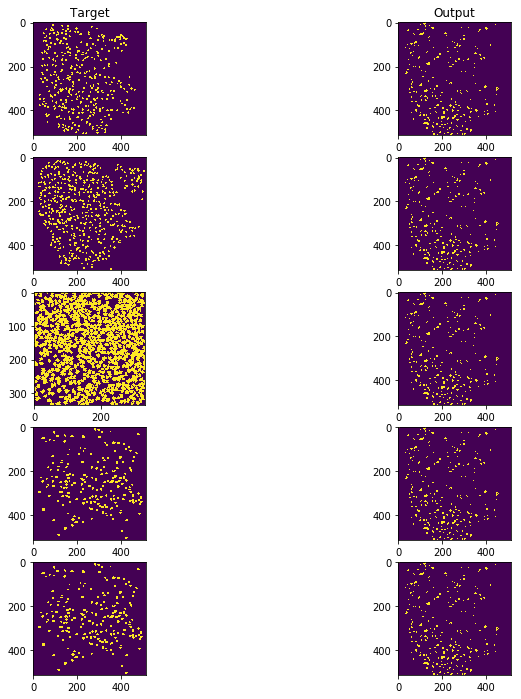

In [146]:
plt.figure()
fig, ax = plt.subplots(nrows=5,ncols=2, figsize=(12,12))
ax[0][0].title.set_text("Target")
ax[0][1].title.set_text("Output")


for i in range(len(train_tgt)):
    ax[i][0].imshow(train_tgt[i].numpy())
    ax[i][1].imshow(train_out_mod[i])

plt.tight_layout

In [130]:
train_out_mod = []

for n in range(len(train_out)):
    out_data = train_out[n].data.cpu().numpy()
    indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
    np.sum(out_data*indicator, axis=1)
    x = np.exp(out_data)
    res = x/x.sum(1)
    pos = np.argmax(res, axis=1)
    train_out_mod.append(pos.squeeze())

In [131]:
train_out_mod

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
  

In [134]:
train_tgt

[
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.LongTensor of size 512x512], 
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.LongTensor of size 512x512], 
     1     1     1  ...      0     0     0
     1     1     1  ...      0     0     0
     1     1     1  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.LongTensor 